In [1]:
import os
import random
import shutil

# Path to your full dataset
source_dir = '/content/drive/MyDrive/sign_new_dataset'

# Paths for the new train and test sets
base_dir = 'split_dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Create the new directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the split ratio
split_ratio = 0.8 # 80% for training, 20% for testing

# Loop through each class folder (e.g., 'A', 'B', 'Nothing')
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        # Create corresponding subfolders in train and test directories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Get a list of all images and shuffle it
        images = os.listdir(class_path)
        random.shuffle(images)

        # Determine the split point
        split_point = int(len(images) * split_ratio)

        # Split the images
        train_images = images[:split_point]
        test_images = images[split_point:]

        # Copy files to the new directories
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("Dataset has been split into 'train' and 'test' folders.")

Dataset has been split into 'train' and 'test' folders.


In [2]:
import os

# IMPORTANT: Replace with the actual path to your folder.
# For example, to check your 'A' folder:
folder_path = '/content/split_dataset/test/B'

try:
  # Get a list of all files in the folder
  file_list = os.listdir(folder_path)

  # Count the number of files in the list
  number_of_files = len(file_list)

  print(f"The folder '{folder_path}' contains {number_of_files} images.")

except FileNotFoundError:
  print(f"Error: The folder '{folder_path}' was not found. Please check the path.")

The folder '/content/split_dataset/test/B' contains 600 images.


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a generator for the training data WITH augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    validation_split=0.2  # This tells the generator how to split the dataset
)

# Create a separate, simpler generator for the validation data
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # This must match the training generator's split
)

# Load training data using the training generator
train_data = train_datagen.flow_from_directory(
    '/content/split_dataset/train',
    target_size=(32, 32),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load validation data using the validation generator
val_data = val_datagen.flow_from_directory(
    '/content/split_dataset/test',
    target_size=(32, 32),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 9600 images belonging to 5 classes.
Found 600 images belonging to 5 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- Build the Model Architecture ---
# This is the balanced, "medium-sized" model we discussed.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(train_data.num_classes, activation='softmax')
])

# --- Compile the Model ---
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model's architecture
model.summary()


# --- Set up Callbacks to Save the Best Model ---
# This callback saves the model only when 'val_accuracy' improves
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# This callback stops training if performance stops improving for 10 epochs
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,917 (308.27 KB)

 Trainable params: 78,917 (308.27 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# --- Train the Model ---
print("\nStarting model training...")
history = model.fit(
    train_data,
    epochs=50, # Train for up to 100 epochs
    validation_data=val_data,
    callbacks=[checkpoint, early_stopping] # Use the callbacks
)
print("\nModel training complete.")


Starting model training...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4824 - loss: 1.2129
Epoch 1: val_accuracy improved from -inf to 0.77833, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.4834 - loss: 1.2109 - val_accuracy: 0.7783 - val_loss: 0.5710
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8204 - loss: 0.4645
Epoch 2: val_accuracy improved from 0.77833 to 0.82833, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8204 - loss: 0.4643 - val_accuracy: 0.8283 - val_loss: 0.4181
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8747 - loss: 0.3097
Epoch 3: val_accuracy improved from 0.82833 to 0.88500, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8747 - loss: 0.3096 - val_accuracy: 0.8850 - val_loss: 0.3583
Epoch 4/50
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9104 - loss: 0.2295
Epoch 4: val_accuracy did not improve from

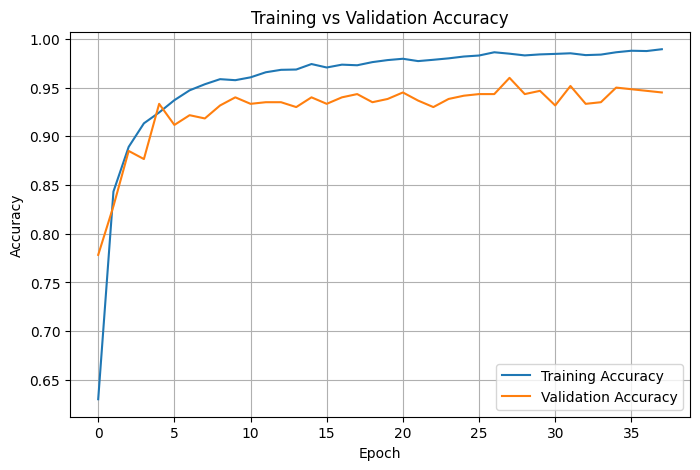

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import numpy as np
import tensorflow as tf
import os

# =================================================================
# COMBINED CELL: CONVERT AND IMMEDIATELY EVALUATE (Corrected)
# =================================================================

print("--- Step 5: Converting to INT8 TFLite Model ---")

# --- This is the conversion code ---
def representative_data_gen():
  for i in range(15):
    images, _ = next(train_data)
    yield [images.astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_quant = converter.convert()

tflite_model_path = 'sign_model_final.tflite'
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model_quant)

model_size_kb = os.path.getsize(tflite_model_path) / 1024
print(f"--> SUCCESS! TFLite model saved. Size: {model_size_kb:.2f} KB\n")


# --- This is the evaluation code, running immediately after ---
print("--- Step 6: Evaluating the Quantized Model ---")

interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

correct_predictions = 0
total_images = len(val_data.filenames)
val_data.reset()

# Loop through each batch from the validation data generator
for i in range(len(val_data)):
    val_images, val_labels = next(val_data) # Get a batch

    # Now, loop through each image IN that batch
    for j in range(len(val_images)):
        # Get a single image and add a new dimension to make it a "batch of 1"
        single_image = np.expand_dims(val_images[j], axis=0)
        true_label_index = np.argmax(val_labels[j])

        # Quantize the single image
        input_scale, input_zero_point = input_details[0]['quantization']
        quantized_image = np.int8(single_image / input_scale + input_zero_point)

        # Set the tensor for the single image and run inference
        interpreter.set_tensor(input_details[0]['index'], quantized_image)
        interpreter.invoke()

        # Get the prediction and compare
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_label_index = np.argmax(output_data)
        if predicted_label_index == true_label_index:
            correct_predictions += 1

accuracy = (correct_predictions / total_images) * 100
print("----------------------------------------------------------")
print(f"Accuracy of quantized INT8 model on validation data: {accuracy:.2f}%")
print("----------------------------------------------------------")

--- Step 5: Converting to INT8 TFLite Model ---
Saved artifact at '/tmp/tmph3z3599m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  140674313405264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674313406032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674313407568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674313405648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674313408912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674313409104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674313406992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140674313409296: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


--> SUCCESS! TFLite model saved. Size: 83.94 KB

--- Step 6: Evaluating the Quantized Model ---


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


----------------------------------------------------------
Accuracy of quantized INT8 model on validation data: 94.50%
----------------------------------------------------------


In [7]:
import os
from google.colab import files

# --- PURE PYTHON TFLITE to C ARRAY CONVERTER ---

# Define the filenames
tflite_input_file = 'sign_model_final.tflite'
c_output_file = 'sign_model.h'
c_array_name = 'model' # You can change this if you changed the name in your .ino

# Read the TFLite file into a byte array
with open(tflite_input_file, 'rb') as f:
    tflite_content = f.read()

# Get the file size
tflite_size = len(tflite_content)

# Start building the C array string
c_array = f'const unsigned char {c_array_name}[] = {{'
c_array += '\n  '

# Add the byte values in hex format, 12 per line
for i, byte in enumerate(tflite_content):
    c_array += f'0x{byte:02x}, '
    if (i + 1) % 12 == 0:
        c_array += '\n  '

# Finish the C array string
c_array += '\n};\n'
c_array += f'const unsigned int {c_array_name}_len = {tflite_size};\n'

# Write the C array to the .h file
with open(c_output_file, 'w') as f:
    f.write(c_array)

# --- VERIFICATION AND DOWNLOAD ---
model_h_size_kb = os.path.getsize(c_output_file) / 1024
print(f"SUCCESS! Created '{c_output_file}'")
print(f"Final C file size: {model_h_size_kb:.2f} KB")
print("This is the correct file. Downloading now...")

files.download(c_output_file)

SUCCESS! Created 'sign_model.h'
Final C file size: 524.68 KB
This is the correct file. Downloading now...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>